In [215]:
%matplotlib inline

import sys
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set(style='ticks',font_scale=1.5)
from dPCA import dPCA

In [2]:
sys.path.append('/Users/yves/Documents/Code/mec_ephys/packages')

from mecll.rsync import Rsync_aligner
from mecll.load import load_data
from mecll.proc_beh import get_all_transition, get_transitions_state, build_poke_df, get_in_task_pokes
from mecll.proc_neural import get_all_resps, get_mean_resps
from mecll.plot.plot_activity_on_graph import plot_activity_on_graph, plot_cell
from mecll.SVD_analysis import get_mean_activity_matrix

In [3]:
#want to construct a de-meaned matrix of task representations
# want an array of (10, 100, 6, 250)
#(n_trials,n_neurons,n_states,task_nr,n_timepoints)

In [163]:
root_path = '/Users/yves/Downloads/example_files/'
out = load_data(root_path)
spkT,spkC,single_units,events,lines,aligner = out

In [164]:
df = build_poke_df(lines,events)


In [165]:
poke_dict_t1 ={}
poke_dict_t2 = {}
for port_nr in np.unique(df['port'].values):
    for task_nr in range(2):
        task_nr = str(task_nr)
        v = df.loc[(df['port']==port_nr) &
                   #(df['correct']==True) & 
                   #(df['next_correct']==True) &
                   #(df['reward']==True) &
                   #(df['port_repeat']==False) & 
                   (df['task_nr']==task_nr)
                  ]['time'].values
        #v = np.array(v).astype('float')
        if task_nr=='0':
            print(task_nr,len(v),str(port_nr))
            poke_dict_t1[str(port_nr)] = [float(i) for i in v]
        else:
            poke_dict_t2[str(port_nr)] = [float(i) for i in v]
            
        
        if port_nr==8:
            poke_dict_t1['task_nr'] = str(task_nr)
            poke_dict_t2['task_nr'] = str(task_nr)
            poke_dict_t1['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            poke_dict_t2['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            poke_dict_t1['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]
            poke_dict_t2['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]




0 91 0
0 90 1
0 99 2
0 75 3
0 110 4
0 45 5
0 70 6
0 86 7
0 43 8


In [166]:
window0 = 6000
window1 = 6000
out1 = get_all_resps(aligner,poke_dict_t1,single_units,spkT,spkC,get_time_mean=False,
                     window0=window0,window1=window1)
all_resps_g1_single_trial, (all_resps1_g1_single_trial,all_resps2_g1_single_trial) = out1
out2 = get_all_resps(aligner,poke_dict_t2,single_units,spkT,spkC,get_time_mean=False,
                     window0=window0,window1=window1)
all_resps_g2_single_trial, (all_resps1_g2_single_trial,all_resps2_g2_single_trial) = out2

In [167]:
trial_bound = int(np.min([len(i) for i in all_resps_g1_single_trial[0]] +
                         [len(i) for i in all_resps_g2_single_trial[0]]))

In [168]:
poke_dict_t1['seq']

[0, 4, 5, 7, 1, 8, 2, 3, 6]

In [242]:
downsample_factor =  150
downsample_factor = int(all_resps_g1_single_trial[neuron_ix][trial_type][0].shape[0]/downsample_factor)
n_neurons = len(all_resps_g1_single_trial)
data_array = []
for trial_type in poke_dict_t2['seq']:
    tmp = []
    for neuron_ix in range(n_neurons):
        tmp_ = np.array(all_resps_g1_single_trial[neuron_ix][trial_type][:trial_bound])
        tmp_ = tmp_.reshape(tmp_.shape[0],-1,downsample_factor).mean(axis=1)
        tmp_ = gaussian_filter1d(tmp_,3,axis=1)

        tmp.append(tmp_)
    data_array.append(tmp)
    
data_array = np.array(data_array).swapaxes(0,2)
data_array = data_array.reshape(list(data_array.shape) + [1])

In [243]:
all_resps_g1_single_trial[neuron_ix][trial_type][0].shape

(12000,)

In [244]:
data_array.shape

(23, 320, 9, 80, 1)

In [245]:

data_array2 = []
for trial_type in poke_dict_t1['seq']:
    tmp = []
    for neuron_ix in range(n_neurons):
        tmp_ = np.array(all_resps_g2_single_trial[neuron_ix][trial_type][:trial_bound])
        tmp_ = tmp_.reshape(tmp_.shape[0],-1,downsample_factor).mean(axis=1)
        tmp_ = gaussian_filter1d(tmp_,3,axis=1)

        tmp.append(tmp_)
    data_array2.append(tmp)
    
data_array2 = np.array(data_array2).swapaxes(0,2)
data_array2 = data_array2.reshape(list(data_array2.shape) + [1])

In [246]:
trialR = np.concatenate([data_array,data_array2],axis=4).swapaxes(-1,-2)

In [247]:
# trial-average data
R = np.mean(trialR,0)

n_neurons = R.shape[0]
## center data
R -= np.mean(R.reshape((n_neurons,-1)),1)[:,None,None,None]
print(R.shape)

(320, 9, 2, 80)


In [248]:
dpca = dPCA.dPCA(labels='sgt',regularizer='auto',n_components=10)
dpca.protect = ['t']

You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.


In [249]:
Z = dpca.fit_transform(R,trialR,)

Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.2689264815224247
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


In [240]:
{'s': [0.4081412629152196,
  0.16497906338324353,
  0.037920790361828084,
  0.00830891344410804,
  0.0065253866202620225,
  0.003283164395841156,
  0.002109859416558707,
  0.0015547726914052998,
  2.2752260710492945e-32,
  2.699248715354749e-33],
 'g': [0.04858949899038975,
  5.938101581060705e-33,
  2.1097632305386625e-33,
  1.1338151392135025e-33,
  4.324609659317553e-34,
  5.535222623528896e-34,
  4.812385876255903e-34,
  2.4563713982895877e-34,
  1.8727357150358492e-34,
  2.21294980898859e-34],}

{'s': [0.4081412629152196,
  0.16497906338324353,
  0.037920790361828084,
  0.00830891344410804,
  0.0065253866202620225,
  0.003283164395841156,
  0.002109859416558707,
  0.0015547726914052998,
  2.2752260710492945e-32,
  2.699248715354749e-33],
 'g': [0.04858949899038975,
  5.938101581060705e-33,
  2.1097632305386625e-33,
  1.1338151392135025e-33,
  4.324609659317553e-34,
  5.535222623528896e-34,
  4.812385876255903e-34,
  2.4563713982895877e-34,
  1.8727357150358492e-34,
  2.21294980898859e-34]}

In [250]:
dpca.explained_variance_ratio_

{'s': [0.40814126291521974,
  0.16497906338324378,
  0.0379207903618281,
  0.008308913444108045,
  0.006525386620262025,
  0.0032831643958411614,
  0.002109859416558709,
  0.0015547726914053,
  1.4874144062290436e-32,
  2.209569046099094e-33],
 'g': [0.048589498990389744,
  6.198069721465417e-33,
  1.9762681490023785e-33,
  1.337962981362989e-33,
  4.266067887131e-34,
  3.151437755650295e-34,
  9.947765004365452e-34,
  5.383167762898067e-34,
  2.9181356198251776e-34,
  3.784059699589374e-34],
 't': [0.0008673265560049947,
  0.0006592626681729801,
  0.0005470927130335168,
  0.00036991882745927325,
  0.0003106509464115016,
  0.00023579447000296255,
  0.00017173332150074918,
  8.924713368860304e-05,
  3.4296362811994306e-05,
  2.5673959238748975e-05],
 'sg': [0.023649461314086524,
  0.005605034765668759,
  0.004623063966668191,
  0.003281734897679179,
  0.0018202387715866644,
  0.0011930863250385214,
  0.0008235543881590075,
  0.0002707419490449534,
  6.764835740616485e-33,
  3.3591702951

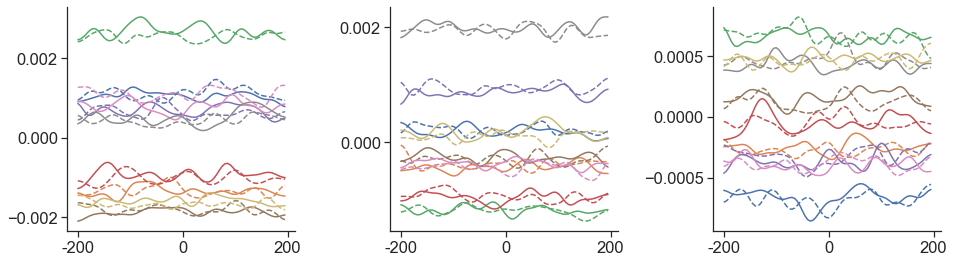

In [230]:
plt.figure(figsize=(18,4))
clrs = seaborn.color_palette(n_colors=9)
for component_nr in range(3):
    plt.subplot(1,4,component_nr+1)
    for s_ in range(9):
        plt.plot(Z['s'][component_nr,s_,0],c=clrs[s_])
        plt.plot(Z['s'][component_nr,s_,1],c=clrs[s_],linestyle='--')
    plt.locator_params('y',nbins=3)
    plt.xticks([-0,40,80],[-200,0,200])
plt.tight_layout()
seaborn.despine()


In [226]:
1/5

0.2

ValueError: x and y must have same first dimension, but have shapes (100,) and (2, 100)

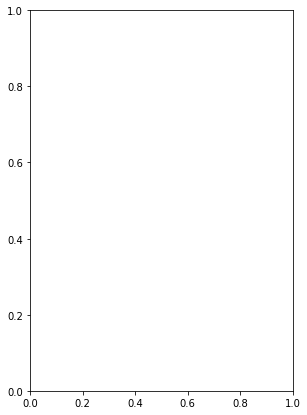

In [122]:
T = 100
S = 9
time = np.arange(T)

plt.figure(figsize=(16,7))
plt.subplot(131)

for s in range(S):
    plt.plot(time,Z['t'][0,s])

plt.title('1st time component')
    
plt.subplot(132)

for s in range(S):
    plt.plot(time,Z['s'][0,s])

plt.imshow(significance_masks['s'][0][None,:],extent=[0,250,amin(Z['s'])-1,amin(Z['s'])-0.5],aspect='auto',cmap='gray_r',vmin=0,vmax=1)
plt.ylim([amin(Z['s'])-1,amax(Z['s'])+1])

plt.title('1st stimulus component')
    
plt.subplot(133)

for s in range(S):
    plt.plot(time,Z['st'][0,s])

dZ = amax(Z['st'])-amin(Z['st'])
plt.imshow(significance_masks['st'][0][None,:],extent=[0,250,amin(Z['st'])-dZ/10.,amin(Z['st'])-dZ/5.],aspect='auto',cmap='gray_r',vmin=0,vmax=1)
plt.ylim([amin(Z['st'])-dZ/10.,amax(Z['st'])+dZ/10.])
    
plt.title('1st mixing component')
